In [26]:
import json
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_validate

### A teszt eredmények, a parameter-test programból:

In [27]:
testLocations = [
    "./parametertestResults/sampleprogram.json",
    "./parametertestResults/ebizzy.json",
    "./parametertestResults/ctx-clock.json",
    "./parametertestResults/fs_mark.json",
    "./parametertestResults/stream.json",
    "./parametertestResults/glmark2.json"
]
testNameList = [
    "sampleprogram",
    "ebizzy",
    "ctx-clock",
    "fs_mark",
    "stream",
    "glmark2"
]

* avgLst(lst) - paraméterként megkap egy listát, és visszaadja az átlagukat
* getIntervals - paraméterként megkapja egy json adathalmazt és végigiterál az eredményeken, majd visszaadja az adathalmazban lévő legjobb és legrosszabb elemet(minMaxLst).
* featureScale(value,intervalMax,intervalMin) - Ennek segítségével normalizálom az adatokat, így az eredmények 0 - 1 közé fognak esni. Ez későbbiekben szükséges nekem, mivel ezeket még kategorizálni fogom.
* getPredictionDf(predictions_lst,tType,df) - Ez a függvény az output értékeit felhasználva, kéri le a pontosan megegyező paraméterű elemet. Ellenörzés céljából írtam, így látható hogy azokkal a paraméterekkel amiket kaptunk, milyen értéket értem én el, tesztelés során. 

In [28]:
def avgLst(lst):
    if(isinstance(lst,list)):
        return sum(lst)/len(lst)
    else:
        return lst

def getIntervals(data):
    intervalTop,intervalBottom = 0.0,float(avgLst(data["measurements"][0]["results"]))
    for j in data["measurements"]:
        if(float(avgLst(j["results"])) > intervalTop):
            intervalTop = float(avgLst(j["results"]))
        if(float(avgLst(j["results"])) < intervalBottom):
            intervalBottom = float(avgLst(j["results"]))
    minMaxLst = [intervalBottom,intervalTop]
    return minMaxLst

def featureScale(value,intervalMax,intervalMin):
    return (value-intervalMin)/(intervalMax-intervalMin)

def getPredictionDf(predictions_lst,tType,df):
    return df[(df["testType"]==tType) & (df["latency"]==predictions[0][0]) &(df["min_gran"]==predictions[0][1]) &(df["wakeup_gran"]==predictions[0][2]) &(df["priority"]==predictions[0][3]) & (df["vm.swappiness"]==predictions[0][4]) ]

def predictionCheck(dataX,dataY,df):
    data = df[(df["testType"]==dataX[0]) & (df["resultClass"]==dataX[1]) & (df["batchProcess"]==dataX[2]) & (df["serverWorkload"]==dataX[3]) & (df["swap"]==dataX[4]) & (df["latency"]==dataY[0]) &(df["min_gran"]==dataY[1]) &(df["wakeup_gran"]==dataY[2]) &(df["priority"]==dataY[3]) & (df["vm.swappiness"]==dataY[4])]
    if data.empty:
        return 0
    else:
        return 1

### Egy listához adom, az összes tesztben elért legjobb és legrosszabb elemet:

In [29]:
classResultIntervals = [0.20,0.4,0.6,0.8]
classIntervalMinMax = []
dataStrLst = []
for i in range(len(testLocations)):
    file = open(testLocations[i])
    data = json.load(file)
    dataStrLst.append(json.dumps(data))
    minMax = getIntervals(data)
    if(i == 0 or i == 2):
        minMax.reverse()
    classIntervalMinMax.append(minMax)

### Kibővítem az adathalmazt új elemekkel mint például:
#### batchProcess 
Batch processzek, akik életük nagy részét számolással töltik. Nekik nem szükséges nagy prioritást állítani, kevesebbszer kerülnek végrehajtásra, viszont ekkor nagyobb időszeletet kapnak. Emiatt hogyha egy processz prioritása nagyobb mint nulla, batchProcess kategóriába kerül.
#### serverWorkload 
Az ütemezőt behangolhatjuk szerver terhelésre, ehhez a min_granularity változónk értékét kell módosítani. A CFS ütemezőben nincsenek konkrétan időszeletek, az időszeletek így számolódnak: 

(latency target)/ (the number of runnable processes)

Nagy létszámú processzek esetén a (latency target) így számolódik: 
kernel.sched_min_granularity_ns * (the number of runnable processes) 

Emiatt amikor nagyobb értéket vesz fel a min_granularity mint az alapbeállítás, serverWorkload kategóriába kerül.
#### swap 
Szüksége van a felhasználónak swap memóriára? Hogyha nincs szüksége 0, egyébként 1.
#### resultClass
A kimeneti értékeket először normalizáltam hogy 0 és 1 között legyenek. Ezután kategóriákba soroltam az értékeket, 

classResultIntervals = [0.20,0.4,0.6,0.8]

         x < 20 : 0
    20 < x < 40 : 1
    40 < x < 60 : 2
    60 < x < 80 : 3
    80 < x < 100: 4
    
Ezzel az inputtal szeretném elérni hogy a legjobb értéket adja a modellem, ezért ezt mindig 4-re állítom.

In [30]:
dataSet = []
for i in range(len(dataStrLst)):
    data_json = json.loads(dataStrLst[i])
    classResult = 0
    for j in data_json["measurements"]:
        swap = 1 if ( int(j["parameters"]["vm.swap"]) > 0 ) else 0                                     
        testType = data_json["testType"]
        testName = data_json["testName"]
        batchProcess = 1 if ( int(j["parameters"]["prio"]) > 0 ) else 0
        serverWorkload = 1 if( int(j["parameters"]["min_gran"]) > 1500000) else 0
        resultNormalized = featureScale(float(avgLst(j["results"])),classIntervalMinMax[i][1],classIntervalMinMax[i][0])
        for k in range(len(classResultIntervals)):
            if(resultNormalized > classResultIntervals[k]):
                classResult = (k+1)
        dataSet.append([testType,testName,batchProcess,classResult,serverWorkload,swap,resultNormalized,int(j["parameters"]["latency"]),int(j["parameters"]["min_gran"]),int(j["parameters"]["wakeup_gran"]),int(j["parameters"]["prio"]),int(j["parameters"]["vm.swap"])],)
df = pd.DataFrame(dataSet,columns=["testType","testName","batchProcess","resultClass","serverWorkload","swap","results","latency","min_gran","wakeup_gran","priority","vm.swappiness"])

 A json eredményekből származó testType változót értékeit, felcserélem ezzel a testTypeMap dictionary-vel. Inputként a teszt típust, az eredmény kategóriát(Amit mindig 4-re próbálok állítani a prediction-knél), batchProcess, serverWorkload típust, és a swap-ot választottam.  Ezek felhasználásával szeretném megkapni a változó értékeket, amik lehetőleg a legjobb választást adják. Az adathalmazt 80% train és 20% test részekre szedtem szét.

In [31]:
testTypeMap = {
    "cpu-s":0,
    "cpu" : 1,
    "system" : 2,
    "disk" : 3,
    "memory" : 4,
    "graphics":5
}
df.testType.replace(to_replace=testTypeMap,inplace=True)
#features
X = df[["testType","resultClass","batchProcess","serverWorkload","swap"]]
#labels
y = df[["latency","min_gran","wakeup_gran","priority","vm.swappiness"]]
#split dataset 80% train 20% test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#model = MultiOutputClassifier(MLPClassifier(solver="lbfgs",hidden_layer_sizes=(9,),activation="tanh",random_state=0,max_iter=10000000)).fit(X_train,y_train)

A modelt már előre betanítottam.

In [32]:
#model.fit(X_train,y_train)      #I already trained the model
model = joblib.load("model.sav") #Load the model

Itt látható egyben az adathalmaz, minden teszt 1024 féle beállítással 5 mintát vett.

In [33]:
#joblib.dump(model,"model.sav") # Save the model
df

,testType,testName,batchProcess,resultClass,serverWorkload,swap,results,latency,min_gran,wakeup_gran,priority,vm.swappiness
0,0,sampleprogram,0,4,0,0,0.987037,100000,100000,0,-20,0
1,0,sampleprogram,0,4,0,1,0.976852,100000,100000,0,-20,33
2,0,sampleprogram,0,4,0,1,0.994444,100000,100000,0,-20,66
3,0,sampleprogram,0,4,0,1,0.988889,100000,100000,0,-20,100
4,0,sampleprogram,0,4,0,0,0.991667,100000,100000,0,-6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6139,5,glmark2,1,1,1,1,0.050000,1000000000,1000000000,999999999,6,99
6140,5,glmark2,1,1,1,0,0.320000,1000000000,1000000000,999999999,19,0
6141,5,glmark2,1,1,1,1,0.210000,1000000000,1000000000,999999999,19,33
6142,5,glmark2,1,1,1,1,0.260000,1000000000,1000000000,999999999,19,66


In [34]:
efficiency = []
trainRange = int( len(df) * 0.8 )
testRange = len(df)-trainRange

dataY = model.predict(X_train)
dataX = X_train.to_numpy()
for j in range(trainRange):
    efficiency.append(predictionCheck(dataX[j],dataY[j],df))
print("A model hatékonysága a tanító mintákon:",metrics.accuracy_score(np.array(efficiency),np.ones(trainRange)))

dataY = model.predict(X_test)
dataX = X_test.to_numpy()
efficiency.clear()
for j in range(testRange):
    efficiency.append(predictionCheck(dataX[j],dataY[j],df))
print("A model hatékonysága a validációs mintákon:",metrics.accuracy_score(np.array(efficiency),np.ones(testRange)))

A model hatékonysága a tanító mintákon: 0.7096642929806715
A model hatékonysága a validációs mintákon: 0.7314890154597233


In [36]:
print("0  - cpu(SingleCore) 1 - cpu\t2 - system\t 3 - disk\t 4 - memory\t 5 - graphics")
print("teszt típusa:")
tType = int(input())
print("a futtatni kivánt program batch process? 0-Nem 1-Igen")
tBatch = int(input())
print("szerver szintű terhelésre lehet számítani? 0-Nem 1-Igen")
tServerWorkload = int(input())
print("swap memóriát igényel? 0-Nem 1-Igen")
tSwap = int(input())

0  - cpu(SingleCore) 1 - cpu	2 - system	 3 - disk	 4 - memory	 5 - graphics
teszt típusa:
0
a futtatni kivánt program batch process? 0-Nem 1-Igen
1
szerver szintű terhelésre lehet számítani? 0-Nem 1-Igen
1
swap memóriát igényel? 0-Nem 1-Igen
1


In [37]:
prediction_arr = [[tType,4,tBatch,tServerWorkload,tSwap]]
prediction_df = pd.DataFrame(prediction_arr,columns=["testType","resultsClass","batchProcess","serverWorkload","swap"])
predictions = model.predict(prediction_df)
print("paraméterek: ",predictions)
getPredictionDf(prediction_arr,tType,df)

paraméterek:  [[666700000 333400000         0        19        33]]


,testType,testName,batchProcess,resultClass,serverWorkload,swap,results,latency,min_gran,wakeup_gran,priority,vm.swappiness
589,0,sampleprogram,1,4,1,1,0.984259,666700000,333400000,0,19,33


### Itt azt próbálom megmutatni hogy kategóriánként, hogyan oszlanak el az értékek

#### Az egész adathalmaz felhasználásával:

1    2370
4    1959
3     965
2     849
0       1
Name: resultClass, dtype: int64

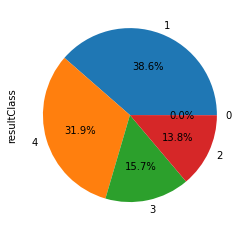

In [38]:
df["resultClass"].value_counts().plot(kind="pie",autopct='%1.1f%%')
df["resultClass"].value_counts()

#### Tesztenként külön külön:

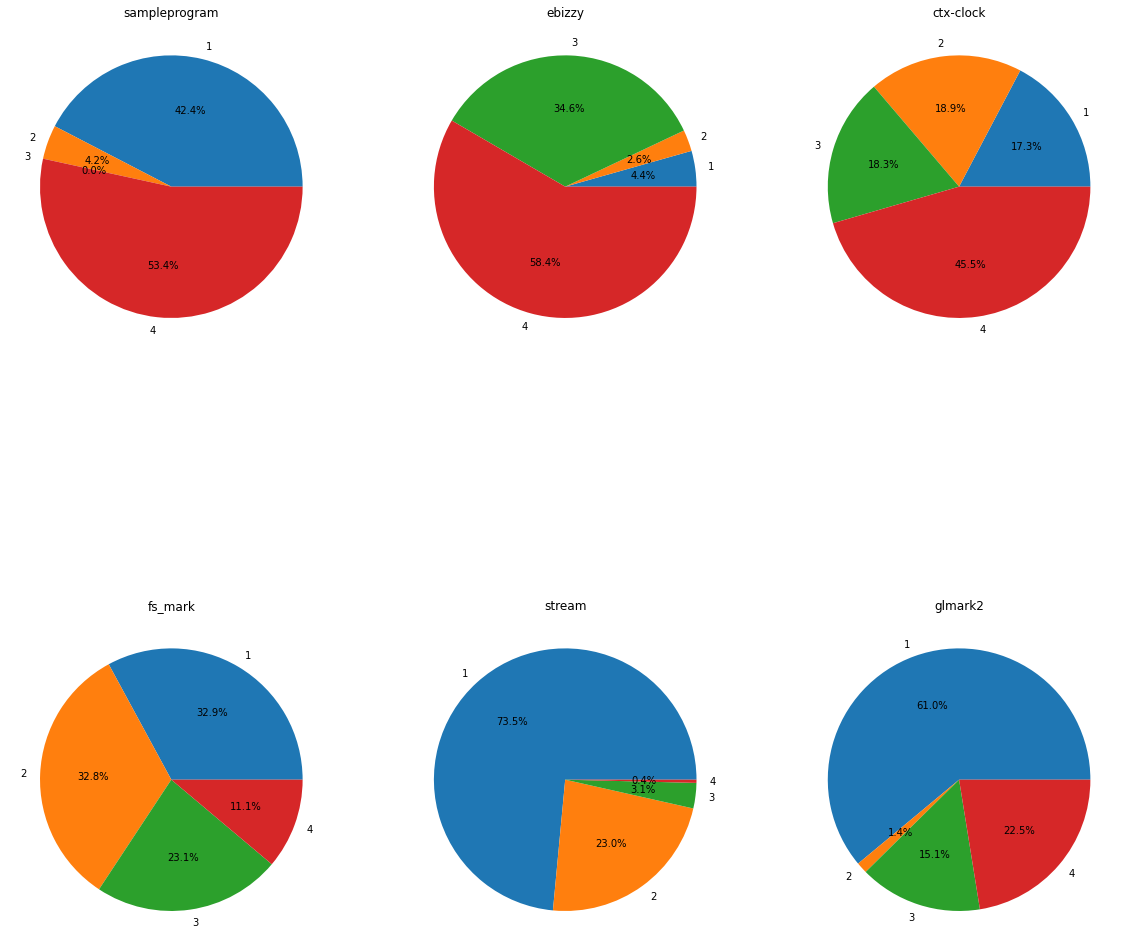

In [39]:
plotLabels=[1,2,3,4]
plotVal=[]
for j in range(len(testLocations)):
    localVal=[]
    for i in range(1,5):
        localVal.append((len(df.loc[(df["testType"]==j ) & (df["resultClass"]==i), "resultClass"].to_numpy())))
    plotVal.append(localVal)
fig,(ax) = plt.subplots(2,3,figsize=(20,20))
eachChart=0
for j in range(2):
    for i in range(3):
        ax[j,i].pie(plotVal[eachChart], labels=plotLabels, autopct='%1.1f%%')
        ax[j,i].set_title(testNameList[eachChart])
        eachChart+=1